In [1]:
#################################################################################################################
#                                                                                                               #
#                                      Section 1 Data Preperation                                               #
#                                                                                                               #
#################################################################################################################


#########################################  User define variables  ###############################################

# User Choice C_MMPTest
# Run test case for MMP? (y/n)
# If True: Default testCase-MMP files 
# If False: User upload Chothia-numbered sequences files to "targeting" and "reference" folders under "./user/data/" respectively.
# Default: True

C_SAMPLE_Test = True

# User Choice C_PIGS
# Use PIGS template for CDR canonical structure? (y/n)
# If True: Default PIGS CDR Canonical structure template under Chothia numbering
# If False: User upload fomatted CDR Canonical structure template under "./user/data/"
# Default: True

C_PIGS = True

# User Choice C_DesireSize
# Use default desire size for targeting dataset? (y/n)
# If True: Default desire size, 44 for the MMP test case, medium for user upload files
# If False: User define desire size for targeting dataset
# Default: True

C_DesireSize = True

# User Choice C_k
# Use default number of iterations? (y/n)
# If True: Default number of iterations, k = 100
# If False: User define number of iterations
# Default: True
C_k = True


#######################################  Define global variables  ###############################################


# SET_NAME = 'IGHV'
# IF_ONLY_HEAVY = True
# CNT_DB = 1
# CNT_TARGET = 1
# REFERENCE_PATH_TESTCASE = './testCase/IGHV/reference-IGHV/'
# TARGETING_PATH_TESTCASE = './testCase/IGHV/targeting-MMP-IGHV/'
# TARGET_DESIRE_SIZE = 134 #44  #IGHV

SET_NAME = 'MMP-cluster'
IF_ONLY_HEAVY = False
CNT_DB = 2
CNT_TARGET = 1
REFERENCE_PATH_TESTCASE = './testCase/MMP-cluster/reference-PDB/'
TARGETING_PATH_TESTCASE = './testCase/MMP-cluster/targeting-MMP/'
TARGET_DESIRE_SIZE = 166

PIGS_PATH = './data/pigs_canonical.txt'
TEMPLATE_PATH = './user/data/'



ITERATION = 100

########################################  Determine variable values  ############################################

if C_SAMPLE_Test == True:
    targeting_direct = TARGETING_PATH_TESTCASE
    reference_direct = REFERENCE_PATH_TESTCASE
else:
    print("Each pair of light and heavy chain sequence should be in the order of LIGHT/HEAVY/LIGHT/HEAVY")
    targeting_direct = TARGETING_PATH
    reference_direct = REFERENCE_PATH
    
if C_PIGS == True:
    canonical_direct = PIGS_PATH
else:
    print("Upload CDR canonical structure templates. ")
    print("In the template, the first column must be the L1, L2, L3, H1, H2, or H3, ")
    print("the second column is the length of the region defined in the first column, ")
    print("starting from the third column, it is the position and candidate amino acid on each position, such as 1 ABC 2 CDETFG.") 
    template_name = input("What is the name of the template?")
    canonical_direct = TEMPLATE_PATH + template_name
    
if C_SAMPLE_Test == True and C_DesireSize == True:
    size = TARGET_DESIRE_SIZE
elif C_SAMPLE_Test == False and C_DesireSize == True:
    size = 'medium'
else:
    size = int(input('What is the desire size for the targeting set?'))
    
if C_k == True:
    iterate = ITERATION
else:
    iterate = int(input("What is the number of iterations?"))


In [2]:
#################################################################################################################
#                                                                                                               #
#                                       Section 2 Feature Extraction                                            #
#                                                                                                               #
#################################################################################################################


############################################  Import libaries  ##################################################

import ASAP.FeatureExtraction as extract


############################################  Function calls   ##################################################

Amino, Num, Germ, DatasetName, DatasetSize = extract.ReadAminoNumGerm(targeting_direct, reference_direct)

OneHotGerm, GermFeatureNames = extract.GetOneHotGerm(Germ, DatasetSize, DatasetName)

OneHotCanon, CanonFeatureNames = extract.GetOneHotCanon(canonical_direct, Amino, Num, DatasetSize, DatasetName)

CDRH3 = extract.GetCDRH3(Amino, Num)

OneHotPI, PIFeatureNames = extract.GetOneHotPI(CDRH3, DatasetSize, DatasetName)

MultiHotMotif, MotifFeatureNames = extract.MultiHotMotif(CDRH3, DatasetSize, DatasetName)

AllFeatureVectors, AllFeatureNames, ExcludeIGHVVectors, ExcludeFeatureNames = extract.GetFeatureVectors(OneHotGerm, GermFeatureNames, OneHotCanon, CanonFeatureNames, OneHotPI, PIFeatureNames, MultiHotMotif, MotifFeatureNames)


############################################  Report section results  #############################################

print("Data:")
for i in range(len(DatasetSize)):
    print(DatasetName[i], ":",DatasetSize[i],)
print("Sum:", sum(DatasetSize))

print("\nNumber of feature values:")
print("Germline:", len(GermFeatureNames),)
print("CDR canonical structures:", len(CanonFeatureNames),)
print("Isoelectric points (pI):", len(PIFeatureNames),)
print("Frequent positional motif:",len(MotifFeatureNames),)
print("Total:", len(AllFeatureNames))

Data:
r1 : 276
r2 : 219
t1 : 166
Sum: 661

Number of feature values:
Germline: 334
CDR canonical structures: 20
Isoelectric points (pI): 8
Frequent positional motif: 42
Total: 404


RanksumsResult(statistic=-154.50220714400487, pvalue=0.0) RanksumsResult(statistic=-191.24982487069587, pvalue=0.0)
Statistical tests (Reference against Targeting) succeed.
(661, 404) 495 166
Average AUC with all features: 
SVM		 0.9906639150154365
Random forest	 0.9892762344087302
AdaBoost	 0.9853817869028717


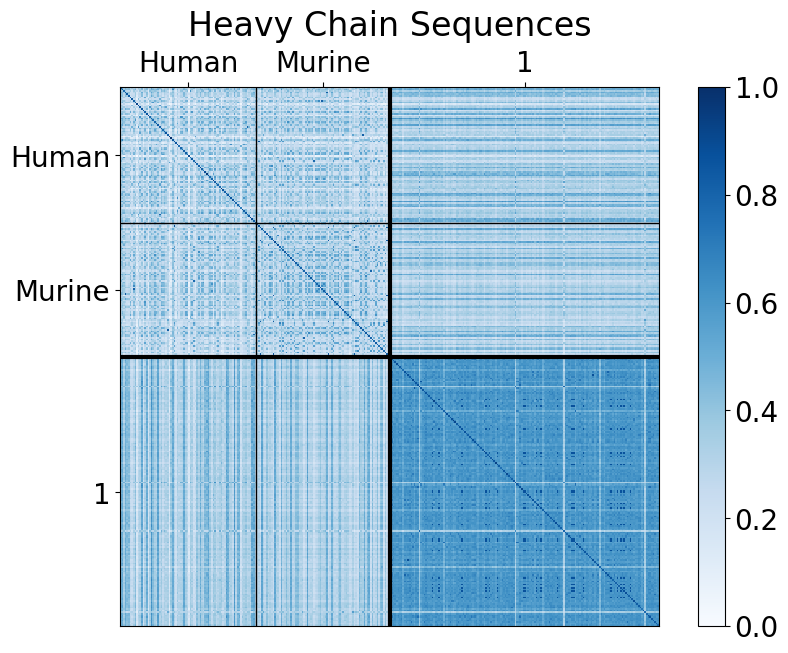

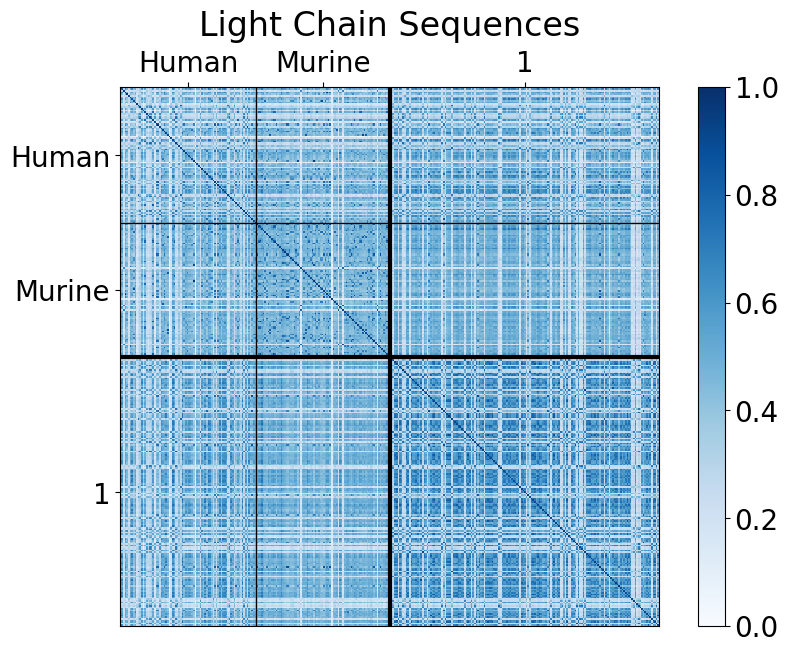

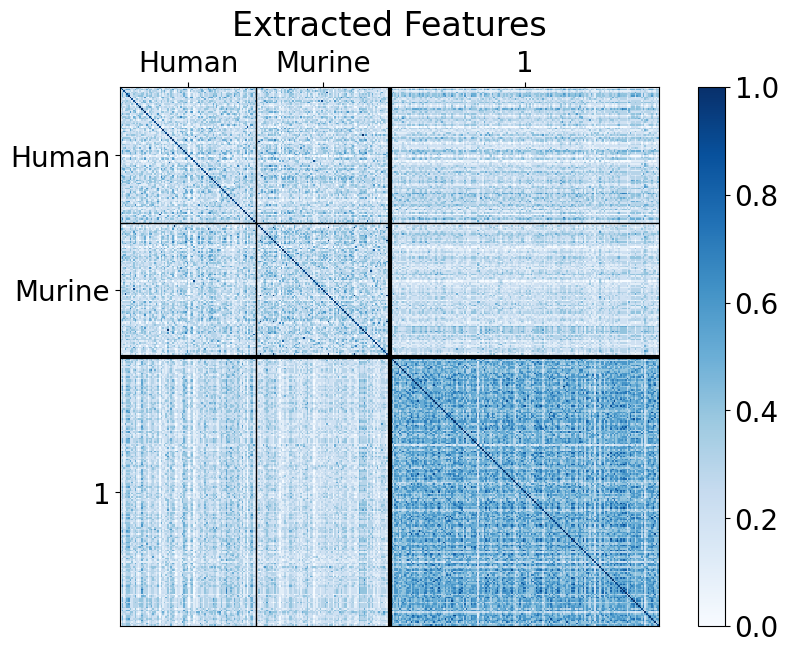

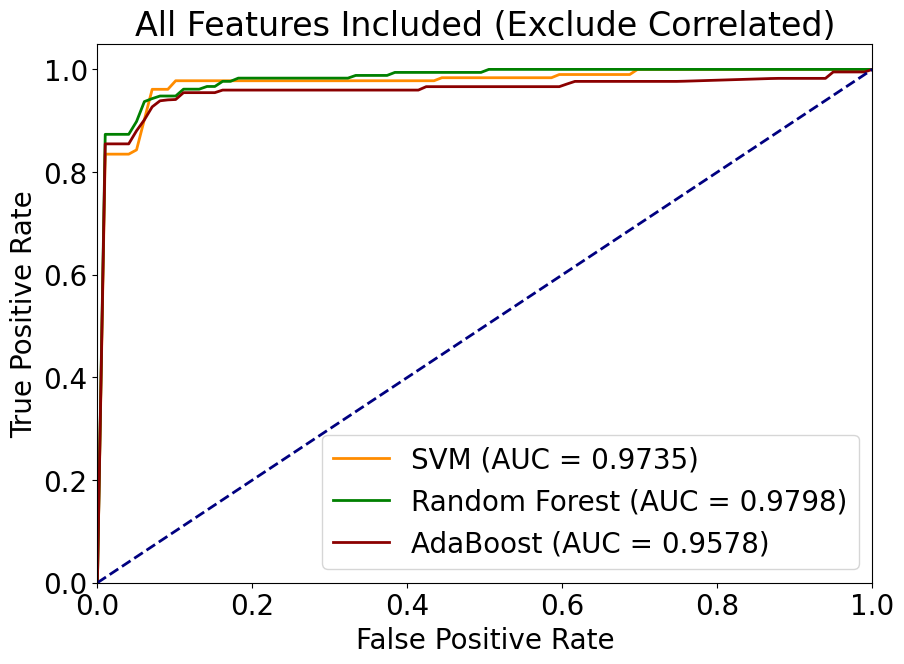

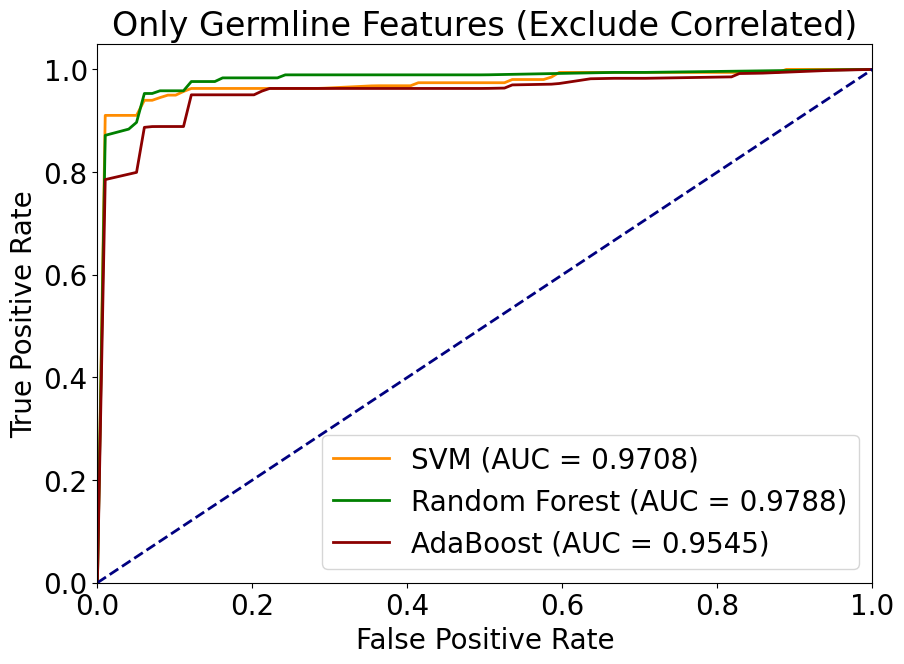

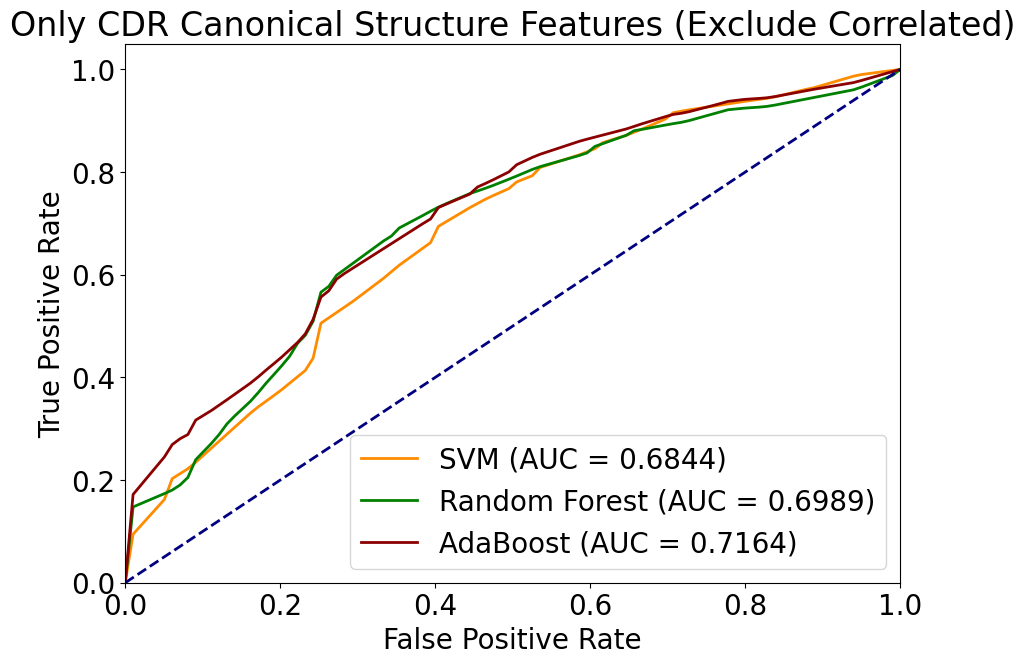

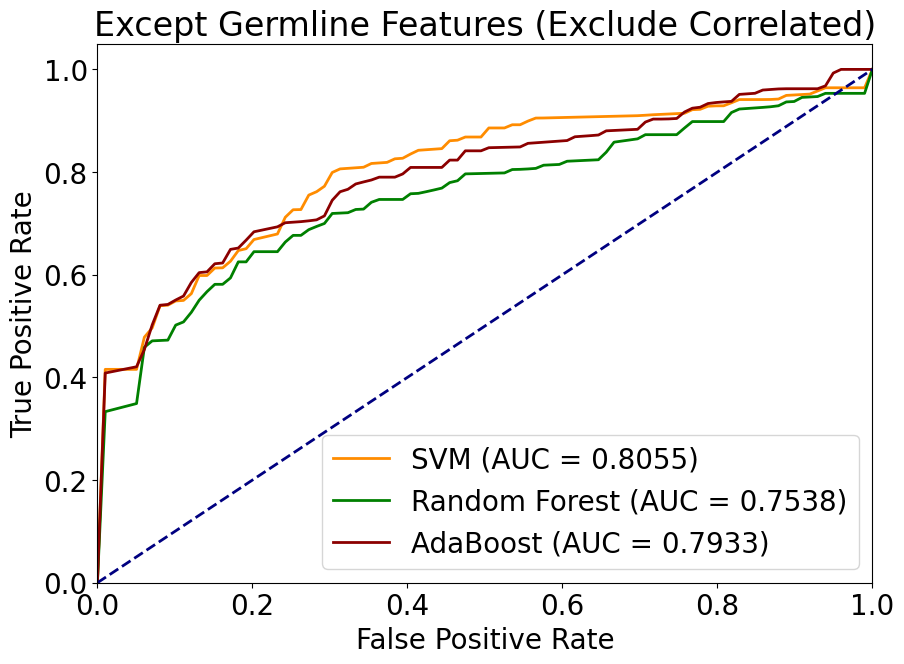

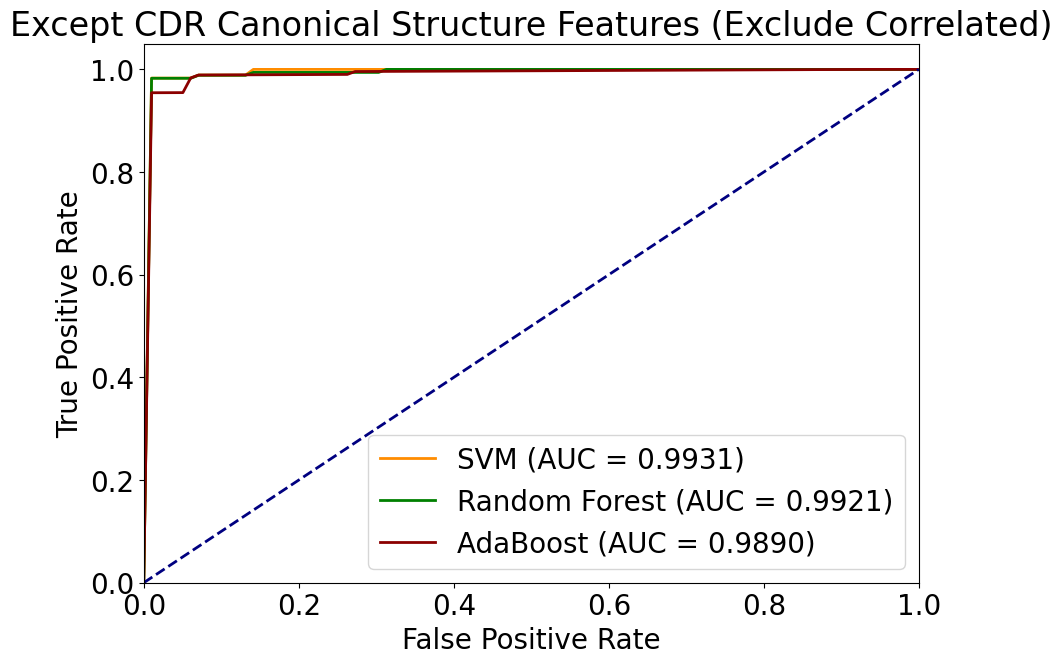

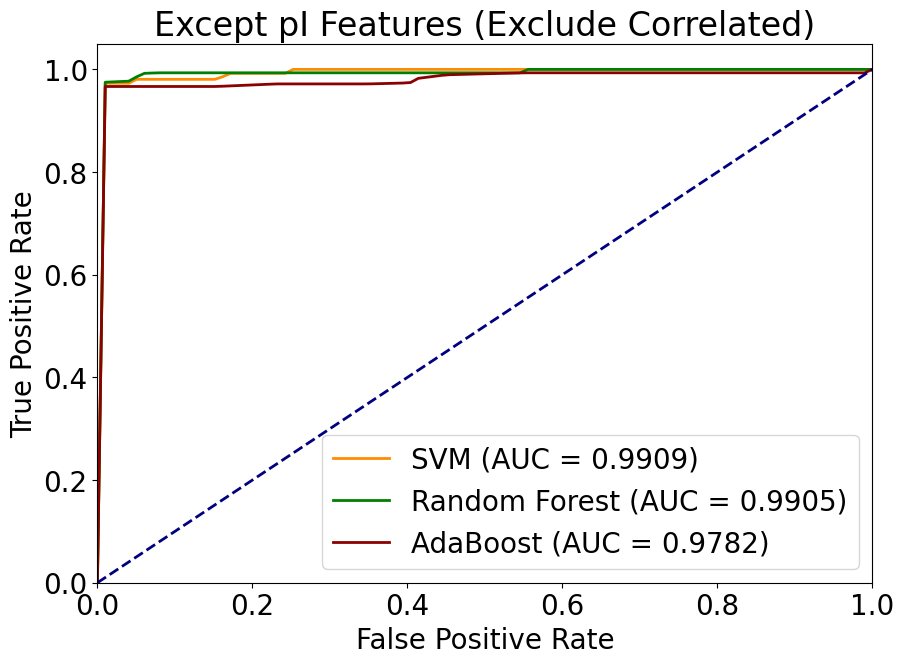

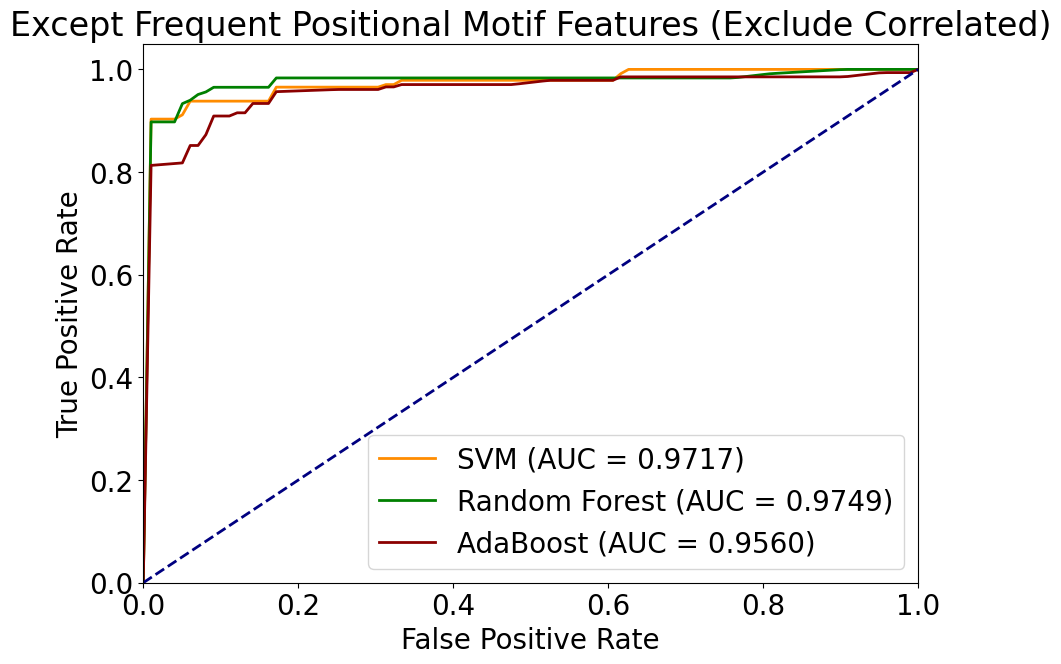

In [3]:
#################################################################################################################
#                                                                                                               #
#                                   Section 3 Sequence and Feature Analysis                                     #
#                                                                                                               #
#################################################################################################################

############################################  Import libaries  ##################################################

import ASAP.SequenceAndFeatureAnalysis as analysis

############################################  Function calls   ##################################################

X_IDS, Y_IDS, SeqName_IDS = analysis.IterationDuplicateSelectFeature(size, iterate, DatasetName, 
                                                                                       DatasetSize, ExcludeIGHVVectors)

######################  Section 3.1 Sequence and feature similarity analysis (Heat map) ##########################

H_Idist, L_Idist = analysis.HeatmapHL(size, iterate, SeqName_IDS, Amino, Num)
analysis.Draw_heatmap(size, H_Idist[1], 'Heavy Chain Sequences', DatasetSize)
if not IF_ONLY_HEAVY:
    analysis.Draw_heatmap(size, L_Idist[1], 'Light Chain Sequences', DatasetSize)
F_Idist = analysis.HeatmapFeature(size, iterate, X_IDS, ExcludeFeatureNames, MotifFeatureNames)
analysis.Draw_heatmap(size, F_Idist[0], 'Extracted Features', DatasetSize)

###############################  Section 3.2 Similarity analysis (Statistical test) #############################

analysis.MultiRankTest(size, iterate, F_Idist, H_Idist, L_Idist)

#######################################  Section 3.3 Salient feature-value analysis  ############################                                     #

analysis.MultiFisherFS(iterate, X_IDS, Y_IDS, DatasetName, DatasetSize, ExcludeIGHVVectors, 
                                         ExcludeFeatureNames)

#######################################  Section 3.4 Classification on segments  ################################  

analysis.MultiAuc(iterate, X_IDS, Y_IDS)
analysis.ROCDrawing(X_IDS[0], Y_IDS[0], GermFeatureNames, CanonFeatureNames, PIFeatureNames, MotifFeatureNames, AllFeatureNames)

analysis.JaccardCoefficientAnalysis(AllFeatureVectors, AllFeatureNames, DatasetSize)

In [7]:
#################################################################################################################
#                                                                                                               #
#                                         Section 4 Design Recommendation                                       #
#                                                                                                               #
#################################################################################################################

############################################  Import libaries  ##################################################

import ASAP.DesignRecommendation as design

############################################  Function calls   ##################################################

design.MultiDecisionTree(iterate, X_IDS, Y_IDS, ExcludeFeatureNames, 'AllFeature')